# Tarefa 3 - Árvores de Decisão

## Aluno: José Ivo Schwade Araújo

### 0. Preparando o ambiente do colab e baixando a base de dados

In [29]:
# Importando as bibliotecas necessárias:
!pip install mahotas gdown tqdm
import mahotas
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gdown
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math


In [2]:
# função que extrai as características da imagem
def describe(image):
	# extrai a média e desvio padrão de cada canal do espaço HSV.
	(means, stds) = cv2.meanStdDev(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
	colorStats = np.concatenate([means, stds]).flatten()
	# converte a imagem para a escala de cinza
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# extrai Haralick texture features
	haralick = mahotas.features.haralick(gray).mean(axis=0)
	# retorna um vetor formado por estatísticas básicas e das Haralick texture features
	return np.hstack([colorStats, haralick])  # colorStats=(6,) haralick=(13,)

In [3]:
url = 'https://drive.google.com/file/d/1bHHgeZ3H75oigySkcZG0S98unOJNft0b/view?usp=sharing'
output = '4scenes.zip'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

# descompactando o conjunto de dados.
# Se já descompactou antes, descomente a linha abaixo
#!rm -rf '4scenes'
!unzip -q '/content/4scenes.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1bHHgeZ3H75oigySkcZG0S98unOJNft0b
From (redirected): https://drive.google.com/uc?id=1bHHgeZ3H75oigySkcZG0S98unOJNft0b&confirm=t&uuid=00ff1530-d6a9-4919-a471-761de8a1a552
To: /content/4scenes.zip
100%|██████████| 54.8M/54.8M [00:00<00:00, 85.5MB/s]


In [4]:
# construindo a base de dados a partir das features extraídas do conjunto 4scenes

imagesPath = './4scenes'
labels = []
data = []

# lista todos os nomes de arquivos presentes no diretório especificado em imagesPath
# o resultado (files) é uma lista de strings, onde cada string é o nome de um arquivo
files = os.listdir(imagesPath)

for image_name in tqdm(files, desc="[INFO] Processando imagens"):
  # extraindo o rótulo das imagens (primeira parte do nome do arquivo)
  label = image_name.split("_")[0]
  # carregando a imagem
  image = cv2.imread(imagesPath + '/' + image_name)
  # extraindo as features da imagem
  features = describe(image)
  # adicionando o rótulo da imagem (classe) em uma lista de rótulos
  labels.append(label)
  # adicionando a imagem (features) ao conjunto de dados
  data.append(features)


[INFO] Processando imagens:   0%|          | 0/1240 [00:00<?, ?it/s]

### 1. Dividindo a base de dados em subconjuntos de treinamento, validação e teste.

In [9]:
(trainData, x, trainLabels, y) = train_test_split(np.array(data), np.array(labels), test_size=0.30, random_state=42)
(testData, valData, testLabels, valLabels) = train_test_split(x, y, test_size=0.5, random_state=42)

### 2. Selecionar a melhor configuração de hiperparâmetros.

Vamos, então, utilizar o conjunto de treino e o conjunto de validação para encontrar a melhor configuração possível para nossos algoritmos de KNN e de Árvore de Decisão.

### KNN:

           scaler  k   distance  accuracy
109  MinMaxScaler  2  cityblock  0.854839


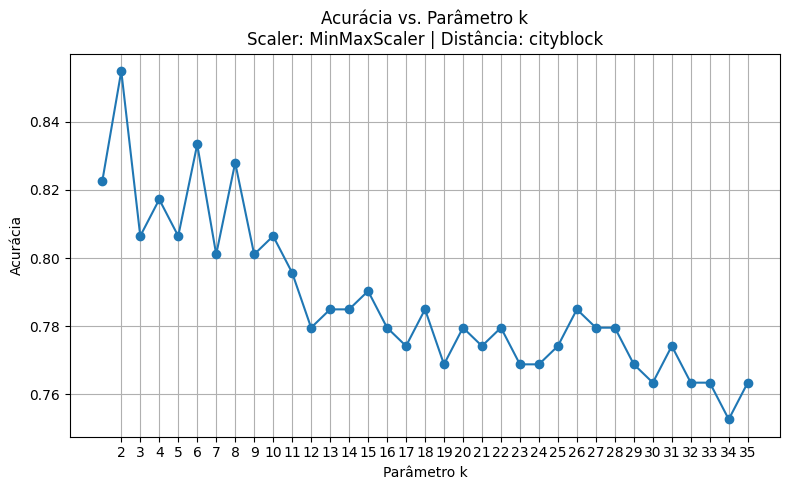

In [10]:
# Codificando labels em números
labelEncoder = LabelEncoder()
trainLabels = labelEncoder.fit_transform(trainLabels)
testLabels = labelEncoder.transform(testLabels)

resultadosKNN = []

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
distances = ['euclidean', 'cityblock', 'chebyshev']
ks = range(1, int(math.sqrt(len(data))) + 1)
# Normalizando utilizando cada Scaler
for scaler_name, scaler in scalers.items():
    X_train = scaler.fit_transform(trainData)
    X_val = scaler.transform(testData)

    K, D = np.meshgrid(ks, distances, indexing='ij')
    for k, distance in zip(K.flatten(), D.flatten()):
        distance = str(distance)
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        knn.fit(X_train, trainLabels)
        Y_pred = knn.predict(X_val)
        accuracy = accuracy_score(testLabels, Y_pred)
        resultadosKNN.append({
            'scaler': scaler_name,
            'k': k,
            'distance': distance,
            'accuracy': accuracy
        })

df_resultadosKNN = pd.DataFrame(resultadosKNN)

# Selecionando a melhor combinação de parâmetros:
print(df_resultadosKNN.sort_values(by='accuracy', ascending=False).head(1))

# Plotando o gráfico da melhor combinação de scaler e métrica para melhor visualização:
scaler_name = df_resultadosKNN.sort_values(by='accuracy', ascending=False)['scaler'].iloc[0]
distance = df_resultadosKNN.sort_values(by='accuracy', ascending=False)['distance'].iloc[0]
subset = df_resultadosKNN[(df_resultadosKNN['scaler'] == scaler_name) & (df_resultadosKNN['distance'] == distance)]

plt.figure(figsize=(8, 5))
plt.plot(subset['k'], subset['accuracy'], marker='o')
plt.xticks(np.arange(1, int(math.sqrt(len(data)))) + 1)
plt.xlabel('Parâmetro k')
plt.ylabel('Acurácia')
plt.title(f'Acurácia vs. Parâmetro k\nScaler: {scaler_name} | Distância: {distance}')
plt.grid(True)
plt.tight_layout()
plt.show()

# Decodificando as labels para uso posterior
trainLabels = labelEncoder.inverse_transform(trainLabels)
testLabels = labelEncoder.inverse_transform(testLabels)


Portanto, para o algoritmo KNN temos que os melhores hiperparâmetros são o scaler `MinMax`, a métrica `cityblock` e o k = 2, com uma acurácia total de 0.854839.

## Árvore de Decisão:

   max_depth  accuracy
5          6  0.790323


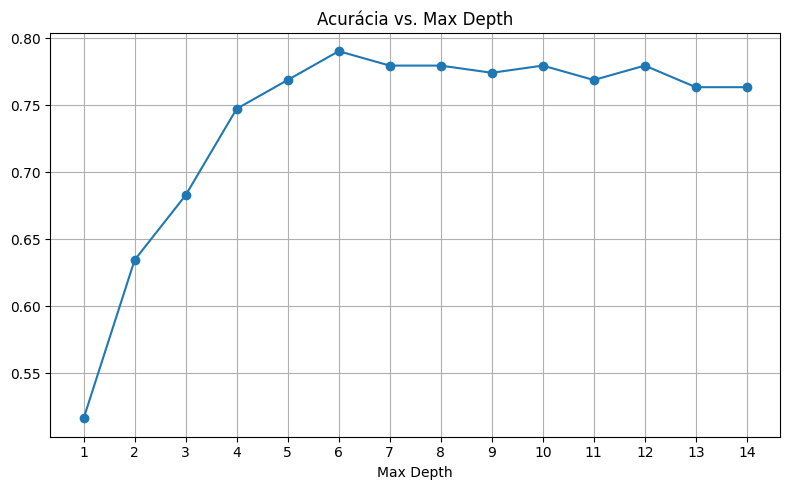

In [19]:
resultadosDecision = []

for max_depth in range(1, 15):
  model = DecisionTreeClassifier(random_state=84, max_depth=max_depth)
  model.fit(trainData,trainLabels)
  Y_pred = model.predict(testData)
  accuracy = accuracy_score(testLabels, Y_pred)
  resultadosDecision.append({
      'max_depth' : max_depth,
      'accuracy' : accuracy
  })
  df_resultadosDecision = pd.DataFrame(resultadosDecision)

# Pegar o resultado com maior precisão
print(df_resultadosDecision.sort_values(by='accuracy', ascending=False).head(1))

#Plotando o gráfico max_depth vs accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_resultadosDecision['max_depth'], df_resultadosDecision['accuracy'], marker='o')
plt.xticks(np.arange(1, 15))
plt.xlabel('Max Depth')
plt.title('Acurácia vs. Max Depth')
plt.grid(True)
plt.tight_layout()
plt.show()

Portanto, para o modelo com o algoritmo de Árvore de decisão temos que o melhor valor para o hiperparâmetro `max_depth` é 6, com uma acurácia total de 0.790323

## 3. Treinando os modelos com a combinação dos conjuntos de treinamento e validação

### KNN:

In [23]:
# Codificando labels em números
labelEncoder = LabelEncoder()
trainLabels = labelEncoder.fit_transform(trainLabels)
valLabels = labelEncoder.transform(valLabels)

resultadosKNN = []

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
distances = ['euclidean', 'cityblock', 'chebyshev']
ks = range(1, int(math.sqrt(len(data))) + 1)

# Normalizando utilizando cada Scaler
for scaler_name, scaler in scalers.items():
    X_train = scaler.fit_transform(trainData)
    X_val = scaler.transform(valData)

    K, D = np.meshgrid(ks, distances, indexing='ij')
    for k, distance in zip(K.flatten(), D.flatten()):
        distance = str(distance)
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        knn.fit(X_train, trainLabels)
        Y_pred = knn.predict(X_val)
        accuracy = accuracy_score(valLabels, Y_pred)


accuracy_KNN = df_resultadosKNN.sort_values(by='accuracy', ascending=False)['accuracy'].iloc[0]
classification_report_KNN = classification_report(valLabels, Y_pred, target_names=labelEncoder.classes_)
confusion_matrix_KNN = confusion_matrix(valLabels, Y_pred)

# Decodificando as labels para uso posterior
trainLabels = labelEncoder.inverse_transform(trainLabels)
valLabels = labelEncoder.inverse_transform(valLabels)


### Naive Bayes:

In [24]:
model = GaussianNB()
model.fit(X_train, trainLabels)

accuracy_NB = accuracy_score(valLabels, model.predict(X_val))
classification_report_NB = classification_report(valLabels, model.predict(X_val))
confusion_matrix_NB = confusion_matrix(valLabels, model.predict(X_val))

### Árvore de decisão:

In [32]:
resultadosDecision = []

for max_depth in range(1, 15):
  model = DecisionTreeClassifier(random_state=84, max_depth=max_depth)
  model.fit(trainData,trainLabels)
  Y_pred = model.predict(testData)
  accuracy = accuracy_score(testLabels, Y_pred)

accuracy_DT = df_resultadosDecision.sort_values(by='accuracy', ascending=False)['accuracy'].iloc[0]
classification_report_DT = classification_report(valLabels, Y_pred, target_names=labelEncoder.classes_)
confusion_matrix_DT = confusion_matrix(valLabels, Y_pred)

### 4. Comparando os 3 modelos:

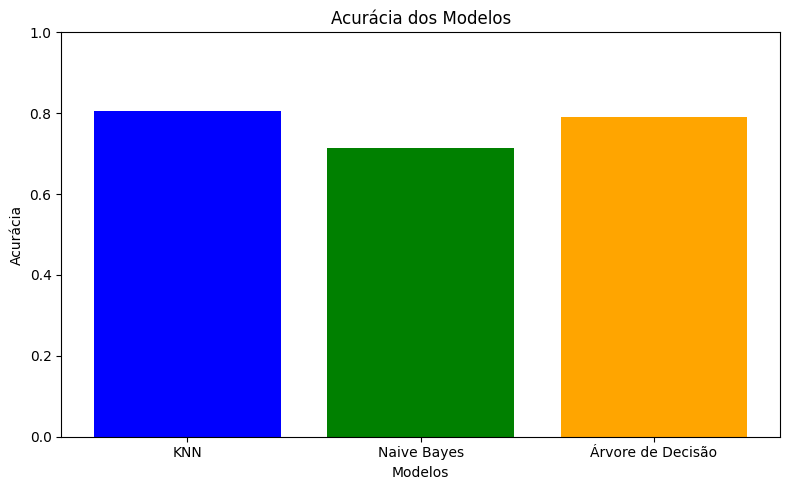

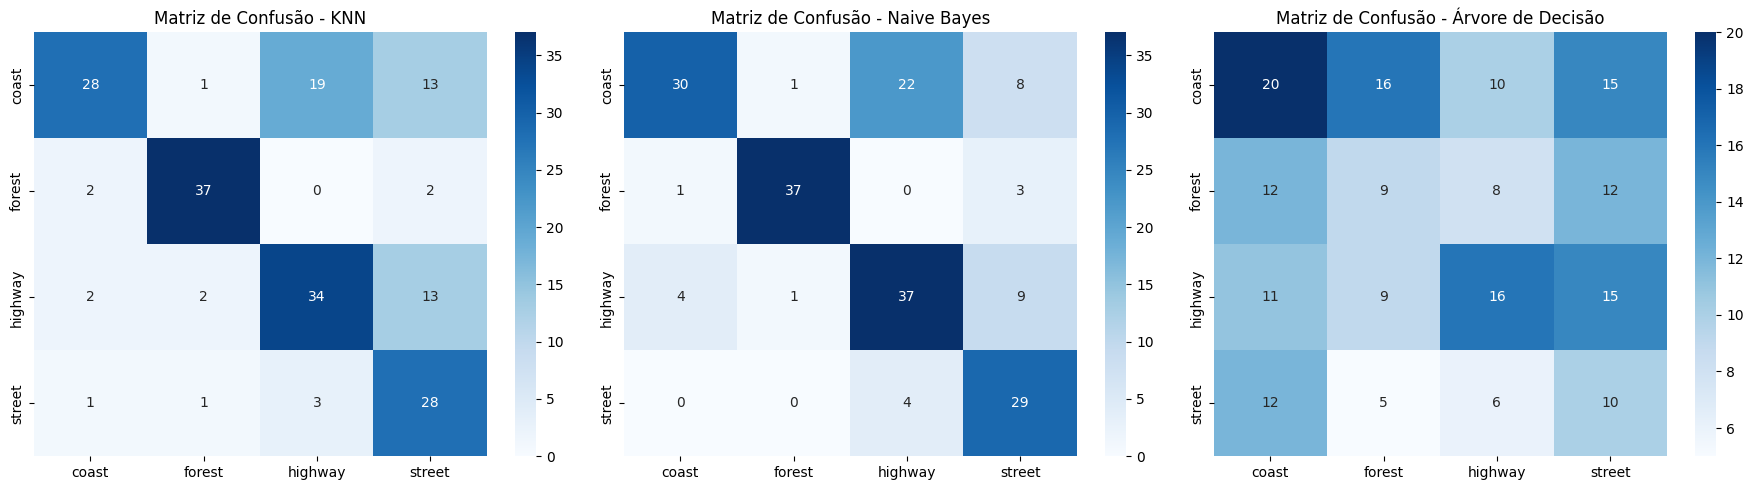

In [35]:
model_names = ['KNN', 'Naive Bayes', 'Árvore de Decisão']
accuracies = [accuracy_KNN, accuracy_NB, accuracy_DT]

# Gráfico de barras das acurácias
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.title('Acurácia dos Modelos')
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Matrizes de confusão para os três modelos
conf_matrices = [confusion_matrix_KNN, confusion_matrix_NB, confusion_matrix_DT]
titles = ['Matriz de Confusão - KNN', 'Matriz de Confusão - Naive Bayes', 'Matriz de Confusão - Árvore de Decisão']

# Plots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ax in enumerate(axes):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=labelEncoder.classes_, yticklabels=labelEncoder.classes_, ax=ax)
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

Portanto, vemos que, embora que o modelo que utiliza a Árvore de Decisão possua uma acurácia maior que o modelo de Naive Bayes, sua matriz de confusão demonstra uma incorretude maior na classificação das imagens.